Graficando Cavity Flow...


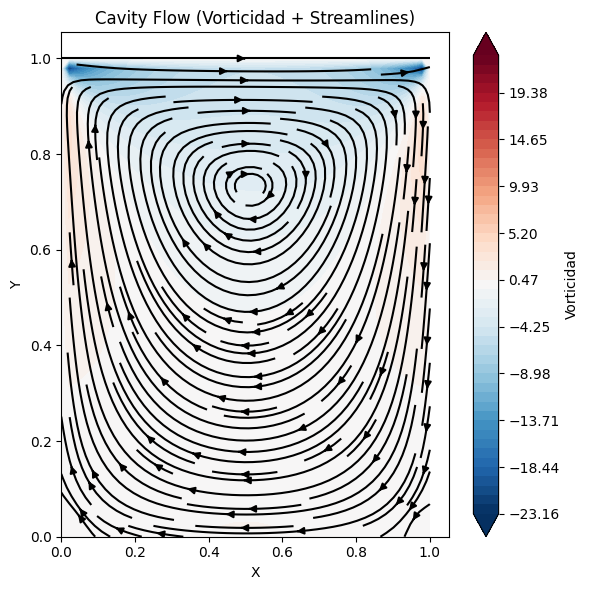

Graficando Kovasznay Flow...


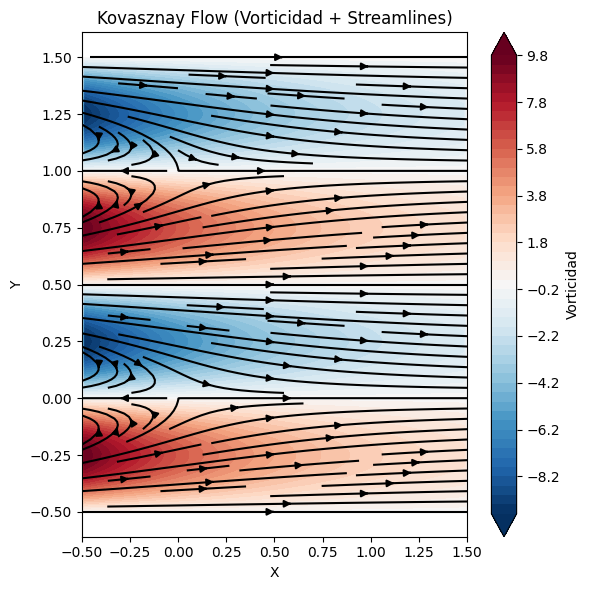

Graficando Taylor-Green Vortex...


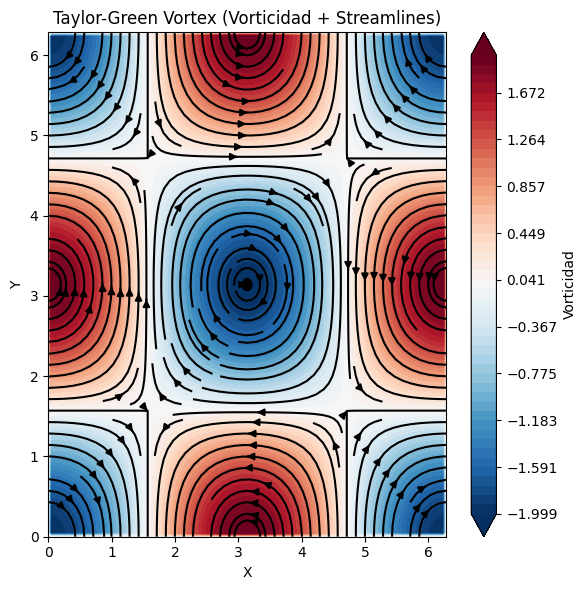

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def compute_vorticity(u, v, dx, dy):
    """
    Calcula la vorticidad 2D (w = dv/dx - du/dy) en una malla uniforme.
    Se asume que u.shape == v.shape.
    """
    ny, nx = u.shape
    w = np.zeros_like(u)
    # Cálculo centrado (ignoramos las fronteras para evitar índices fuera de rango)
    w[1:-1, 1:-1] = ((v[1:-1, 2:] - v[1:-1, :-2]) / (2 * dx)
                     - (u[2:, 1:-1] - u[:-2, 1:-1]) / (2 * dy))
    return w


def plot_cavity_flow(nx=41, ny=41, nt=100):
    """
    Simula y grafica el flujo en cavidad (lid-driven cavity) usando un método de diferencias finitas,
    mostrando la vorticidad en colores y las líneas de corriente.
    """
    # Parámetros de la malla y simulación
    nit = 50
    dx = 1 / (nx - 1)
    dy = 1 / (ny - 1)
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    X, Y = np.meshgrid(x, y)
    
    # Inicialización de campos
    u = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    p = np.zeros((ny, nx))
    b = np.zeros((ny, nx))
    
    rho = 1
    nu = 0.1
    dt = 0.001

    def build_up_b(b, rho, dt, u, v, dx, dy):
        b[1:-1, 1:-1] = (rho * (1/dt *
                          ((u[1:-1, 2:] - u[1:-1, :-2])/(2*dx) +
                           (v[2:, 1:-1] - v[:-2, 1:-1])/(2*dy))
                          - ((u[1:-1, 2:] - u[1:-1, :-2])/(2*dx))**2
                          - 2 * ((u[2:, 1:-1] - u[:-2, 1:-1])/(2*dy) *
                                 (v[1:-1, 2:] - v[1:-1, :-2])/(2*dx))
                          - ((v[2:, 1:-1] - v[:-2, 1:-1])/(2*dy))**2))
        return b

    def pressure_poisson(p, dx, dy, b, nit):
        for q in range(nit):
            pn = p.copy()
            p[1:-1, 1:-1] = (
                ((pn[1:-1, 2:] + pn[1:-1, :-2]) * dy**2 +
                  (pn[2:, 1:-1] + pn[:-2, 1:-1]) * dx**2)
                / (2*(dx**2 + dy**2))
                - dx**2 * dy**2 / (2*(dx**2 + dy**2)) * b[1:-1, 1:-1]
            )
            # Condiciones de contorno para la presión
            p[:, -1] = p[:, -2]
            p[:, 0] = p[:, 1]
            p[0, :] = p[1, :]
            p[-1, :] = 0
        return p

    # Bucle de tiempo para la simulación
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b, nit)
        
        u[1:-1, 1:-1] = (
            un[1:-1, 1:-1]
            - un[1:-1, 1:-1] * dt/dx * (un[1:-1, 1:-1] - un[1:-1, :-2])
            - vn[1:-1, 1:-1] * dt/dy * (un[1:-1, 1:-1] - un[:-2, 1:-1])
            - dt/(2*rho*dx) * (p[1:-1, 2:] - p[1:-1, :-2])
            + nu * (dt/dx**2 * (un[1:-1, 2:] - 2*un[1:-1, 1:-1] + un[1:-1, :-2])
                     + dt/dy**2 * (un[2:, 1:-1] - 2*un[1:-1, 1:-1] + un[:-2, 1:-1]))
        )
        
        v[1:-1, 1:-1] = (
            vn[1:-1, 1:-1]
            - un[1:-1, 1:-1] * dt/dx * (vn[1:-1, 1:-1] - vn[1:-1, :-2])
            - vn[1:-1, 1:-1] * dt/dy * (vn[1:-1, 1:-1] - vn[:-2, 1:-1])
            - dt/(2*rho*dy) * (p[2:, 1:-1] - p[:-2, 1:-1])
            + nu * (dt/dx**2 * (vn[1:-1, 2:] - 2*vn[1:-1, 1:-1] + vn[1:-1, :-2])
                     + dt/dy**2 * (vn[2:, 1:-1] - 2*vn[1:-1, 1:-1] + vn[:-2, 1:-1]))
        )
        
        # Condiciones de contorno para la velocidad
        u[0, :] = 0
        u[-1, :] = 1   # Muro superior en movimiento (velocidad 1)
        u[:, 0] = 0
        u[:, -1] = 0
        
        v[0, :] = 0
        v[-1, :] = 0
        v[:, 0] = 0
        v[:, -1] = 0

    # Una vez finalizada la simulación, calculamos la vorticidad:
    w = compute_vorticity(u, v, dx, dy)
    
    # Para un mapa simétrico de colores, usamos el valor máximo en valor absoluto:
    wmax = np.max(np.abs(w))
    levels = np.linspace(-wmax, wmax, 50)

    plt.figure(figsize=(6,6))
    # Contorno relleno de vorticidad
    plt.contourf(X, Y, w, levels=levels, cmap='RdBu_r', extend='both')
    plt.colorbar(label='Vorticidad')

    # Líneas de corriente (streamlines). Puedes ajustar la densidad si lo deseas.
    plt.streamplot(X, Y, u, v, color='k', density=1.5)

    plt.title('Cavity Flow (Vorticidad + Streamlines)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.tight_layout()
    plt.show()


def plot_kovasznay_flow(nx=100, ny=100):
    """
    Grafica la solución analítica del flujo de Kovasznay,
    mostrando la vorticidad y las líneas de corriente.
    """
    Re = 40
    lam = (Re / 2) - np.sqrt((Re / 2)**2 + 4 * np.pi**2)
    
    x_min, x_max = -0.5, 1.5
    y_min, y_max = -0.5, 1.5
    x = np.linspace(x_min, x_max, nx)
    y = np.linspace(y_min, y_max, ny)
    X, Y = np.meshgrid(x, y)
    
    dx = (x_max - x_min)/(nx - 1)
    dy = (y_max - y_min)/(ny - 1)
    
    # Campos de velocidad analítica
    u = 1 - np.exp(lam * X) * np.cos(2 * np.pi * Y)
    v = (lam / (2 * np.pi)) * np.exp(lam * X) * np.sin(2 * np.pi * Y)
    
    # Calculamos la vorticidad
    w = compute_vorticity(u, v, dx, dy)
    wmax = np.max(np.abs(w))
    levels = np.linspace(-wmax, wmax, 50)

    plt.figure(figsize=(6,6))
    plt.contourf(X, Y, w, levels=levels, cmap='RdBu_r', extend='both')
    plt.colorbar(label='Vorticidad')

    plt.streamplot(X, Y, u, v, color='k', density=1.5)

    plt.title('Kovasznay Flow (Vorticidad + Streamlines)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.tight_layout()
    plt.show()


def plot_taylor_green_flow(nx = 100, ny = 100):
    """
    Grafica el vórtice Taylor-Green (Taylor-Green vortex),
    mostrando la vorticidad y las líneas de corriente.
    """
    x_min, x_max = 0, 2*np.pi
    y_min, y_max = 0, 2*np.pi
    
    x = np.linspace(x_min, x_max, nx)
    y = np.linspace(y_min, y_max, ny)
    X, Y = np.meshgrid(x, y)
    
    dx = (x_max - x_min)/(nx - 1)
    dy = (y_max - y_min)/(ny - 1)
    
    # Campos de velocidad analítica
    u = np.cos(X) * np.sin(Y)
    v = -np.sin(X) * np.cos(Y)
    
    # Calculamos la vorticidad
    w = compute_vorticity(u, v, dx, dy)
    wmax = np.max(np.abs(w))
    levels = np.linspace(-wmax, wmax, 50)

    plt.figure(figsize=(6,6))
    plt.contourf(X, Y, w, levels=levels, cmap='RdBu_r', extend='both')
    plt.colorbar(label='Vorticidad')

    plt.streamplot(X, Y, u, v, color='k', density=1.5)

    plt.title('Taylor-Green Vortex (Vorticidad + Streamlines)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    nx, ny = 50, 50
    nt = 500
    print("Graficando Cavity Flow...")
    plot_cavity_flow(nx=nx, ny=ny, nt=nt)

    print("Graficando Kovasznay Flow...")
    plot_kovasznay_flow(nx=150, ny=150)

    print("Graficando Taylor-Green Vortex...")
    plot_taylor_green_flow(nx=150, ny=150)
